# Download and Extract Dataset and Git Repo

In [1]:
!git clone https://github.com/Dibz15/OpenMineChangeDetection.git
import sys
sys.path.append('/content/OpenMineChangeDetection/')

fatal: destination path 'OpenMineChangeDetection' already exists and is not an empty directory.


In [ ]:
from OpenMineChangeDetection.utils import download_prep_oms2cd
download_prep_oms2cd(output_dir='OMS2CD')

# Install Dependencies

In [2]:
%%capture
!pip install rasterio==1.3.8
!pip install torchgeo==0.4.1
!pip install tiler==0.5.7
!pip install kornia==0.6.12
!pip install lightning==1.9.5

# Prepare Datamodule

In [3]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import torch
import random
import numpy as np
from OpenMineChangeDetection.datasets import OMS2CDDataModule
from torchgeo.transforms import AugmentationSequential
import kornia.augmentation as K


if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

torch.manual_seed(543)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(543)
random.seed(543)
np.random.seed(543)

In [4]:
datamodule = OMS2CDDataModule(root='OMS2CD', bands='rgb', load_area_mask=False,
                              batch_size=16, tile_mode="constant", index_no_mask=True, stride=100)
datamodule.setup('fit')
datamodule.aug = AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5, same_on_batch=False),
    K.RandomVerticalFlip(p=0.5, same_on_batch=False),
    K.RandomGaussianNoise(mean=0.0, std=0.1, same_on_batch=False),
    K.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), same_on_batch=False),
    K.Normalize(mean=datamodule.mean, std=datamodule.std),
    data_keys=["image", "mask"],
)

# Prepare TinyCD Model For Training

In [5]:
from OpenMineChangeDetection.TinyCD.models.cd_lightning import ChangeDetectorLightningModule
pl_model = ChangeDetectorLightningModule(freeze_backbone=False)
pl_model.change_detector.load_state_dict(torch.load("OpenMineChangeDetection/TinyCD/pretrained_models/levir_best.pth", map_location=device))

# for param in pl_model.parameters():
#     param.requires_grad = False

# layers_to_unfreeze = ['_classify']

# for name, param in pl_model.named_parameters():
#     contains_name = False
#     for layer in layers_to_unfreeze:
#         if layer in name:
#             contains_name = True
#     if contains_name:
#         print(f'Unfreezing layer {name}.')
#         param.requires_grad = True

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

<All keys matched successfully>

In [6]:
batch_size = 16
num_workers = 0
max_epochs = 30
fast_dev_run = False

In [8]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", dirpath='checkpoints', save_top_k=3, save_last=True,
    filename='model-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)
early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=20)
logger = TensorBoardLogger(save_dir="experiments_tinycd", name="saved_logs")

trainer = Trainer(
    accelerator=accelerator,
    callbacks=[checkpoint_callback, early_stopping_callback],
    fast_dev_run=fast_dev_run,
    log_every_n_steps=5,
    logger=logger,
    min_epochs=5,
    max_epochs=max_epochs,
    # precision=16
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Train

In [9]:
trainer.fit(model=pl_model, datamodule=datamodule)

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | change_detector | ChangeClassifier | 285 K 
1 | criterion       | BCELoss          | 0     
-----------------------------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.141     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `D

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 15. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


# Test

In [10]:
trainer.test(model=pl_model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.0655243769288063     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0655243769288063}]

In [26]:
from OpenMineChangeDetection.utils import test_TinyCD
datamodule = OMS2CDDataModule(root='OMS2CD', bands='rgb', load_area_mask=False,
                              batch_size=16, tile_mode="constant", index_no_mask=True, stride=100)
datamodule.setup('test')
datamodule.setup('validate')
test_TinyCD(pl_model, device, datamodule, threshold=0.4)


100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


{'acc': 0.9718446619370336,
 'miou': 0.5539881495168981,
 'mf1': 0.6127459008116759,
 'iou_0': 0.9717190502825663,
 'iou_1': 0.13625724875122994,
 'F1_0': 0.9856566445238242,
 'F1_1': 0.23983515709952768,
 'precision_0': 0.9801595507943548,
 'precision_1': 0.3412736727401266,
 'recall_0': 0.9912158659960116,
 'recall_1': 0.1848818615216225,
 'loss': tensor(0.0902, device='cuda:0')}

# Visualize Predictions

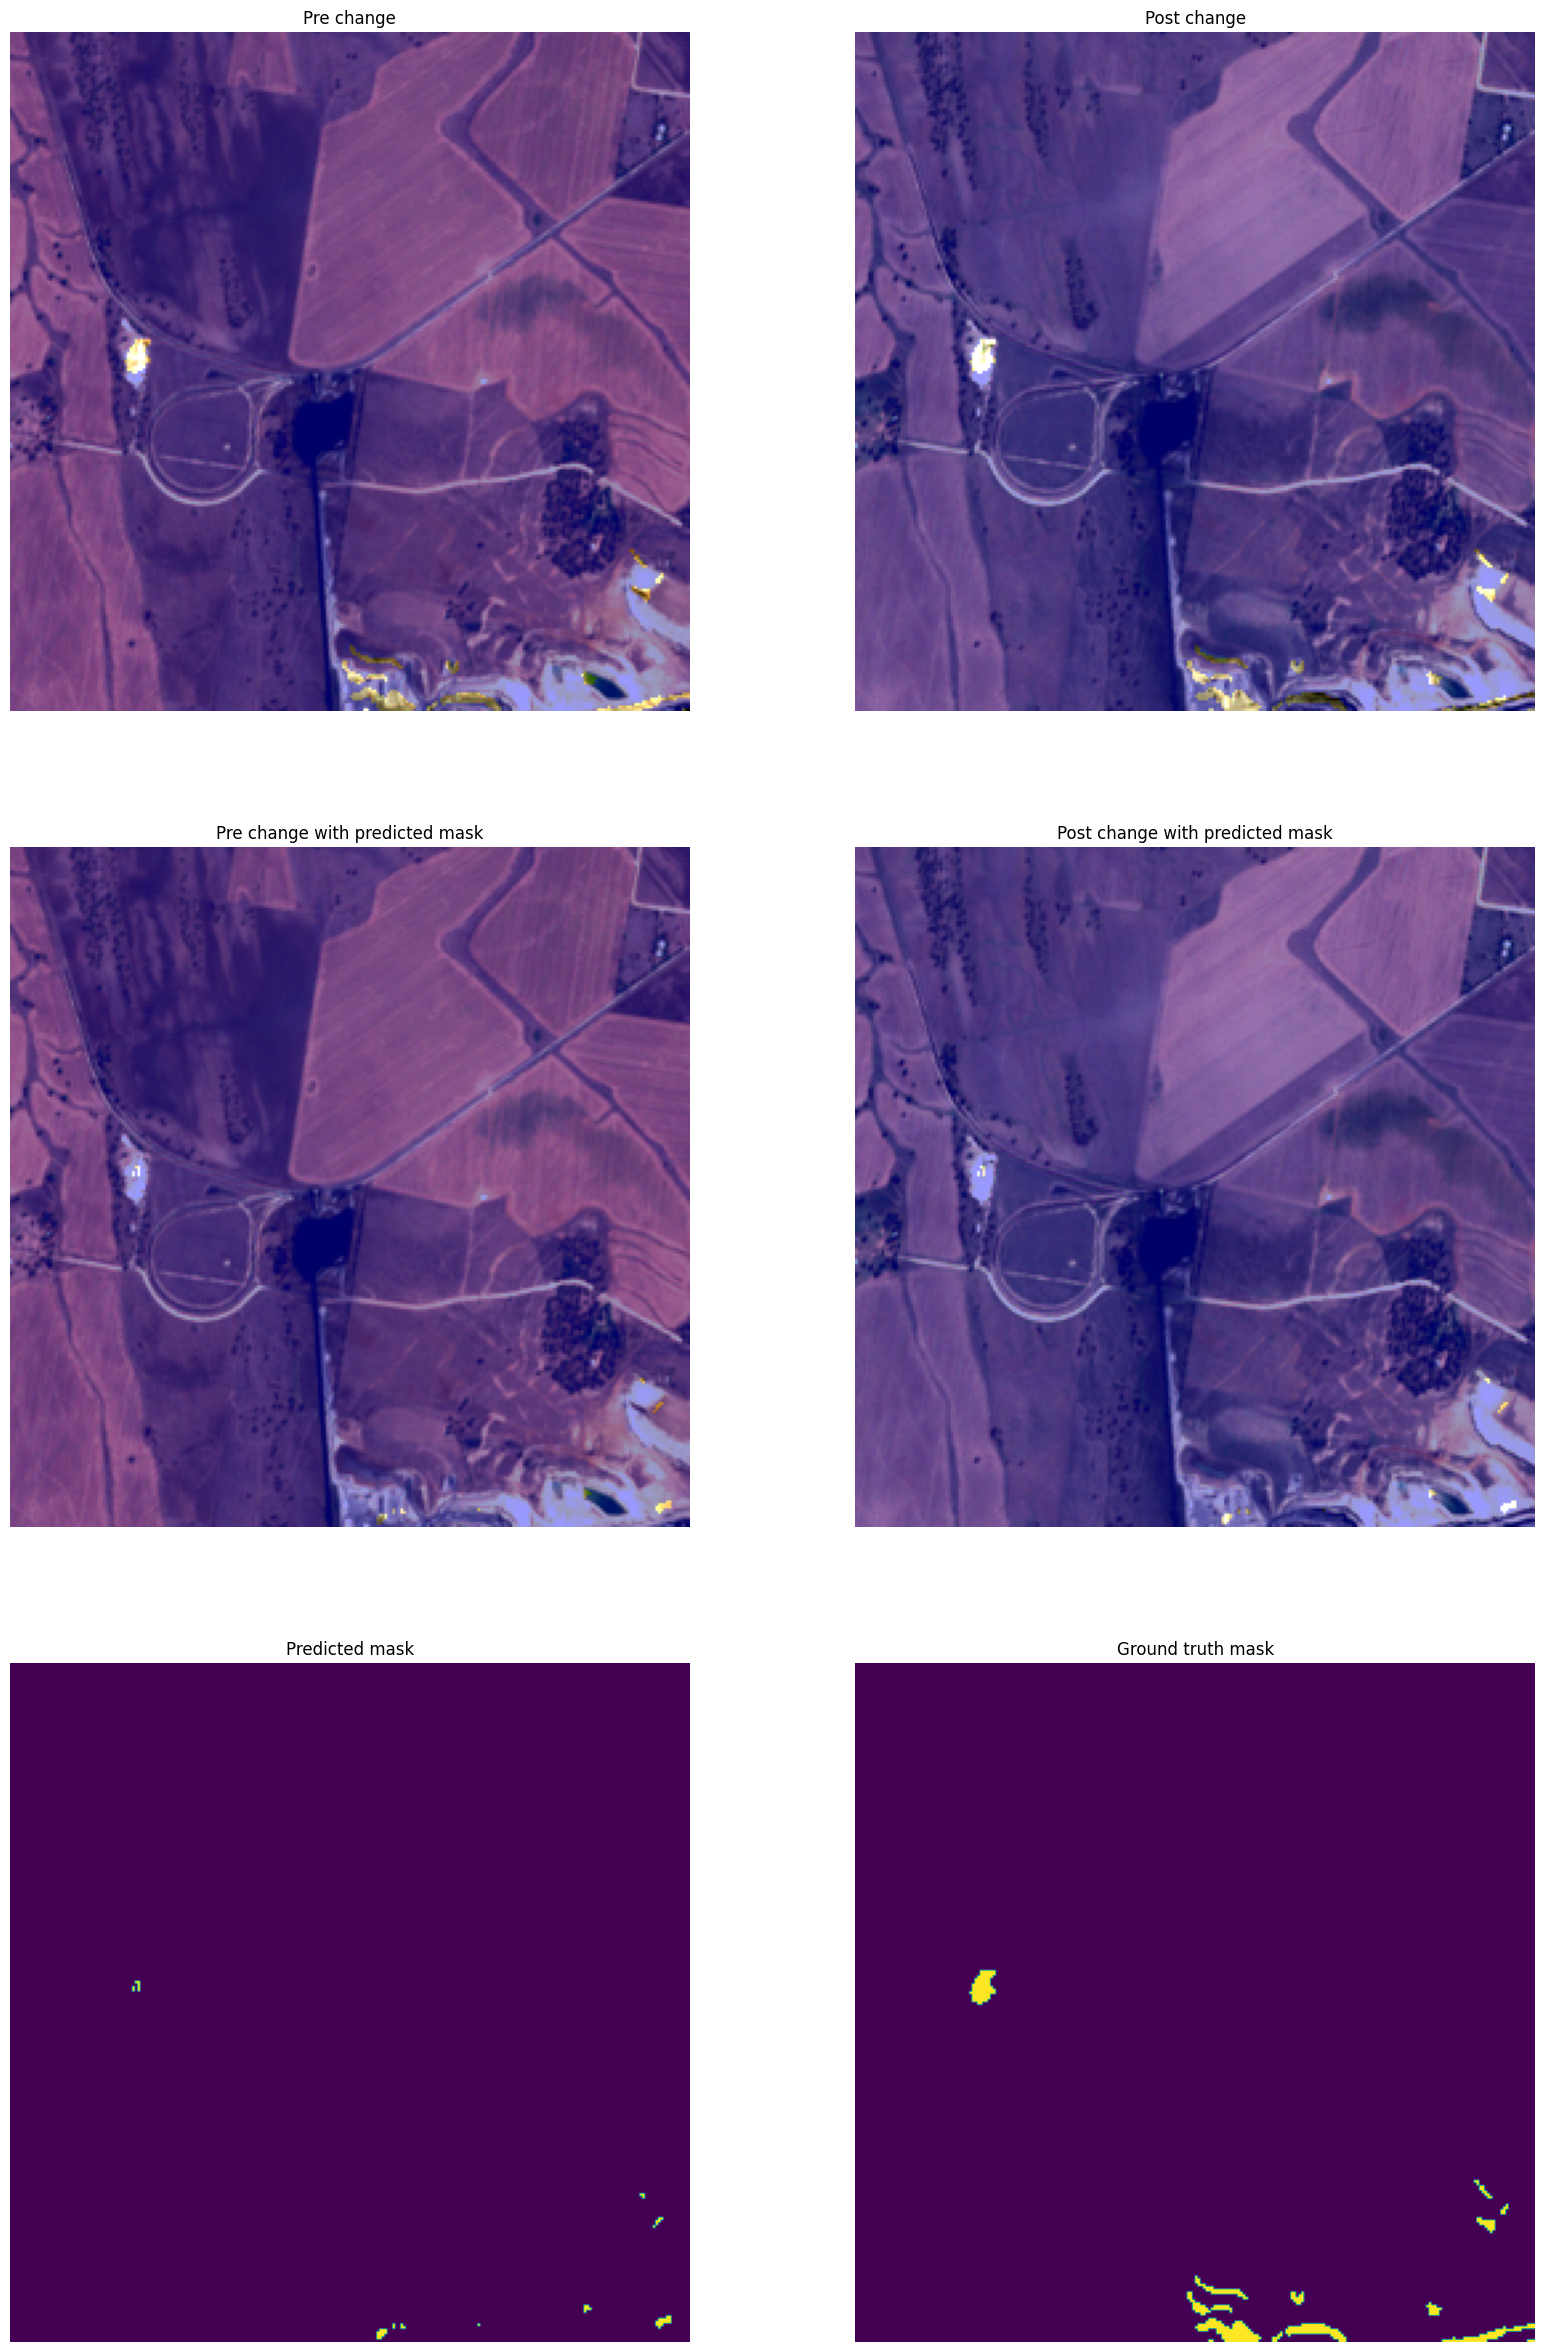

In [ ]:
from OpenMineChangeDetection.utils import plot_prediction
from OpenMineChangeDetection.datasets import OMS2CD

normalize_sample = OMS2CD.GetNormalizeTransform(bands='rgb')
dataset = OMS2CD(root='OMS2CD', split='val', bands='rgb')

plot_prediction(pl_model, normalize_sample(dataset[75]), bands="rgb", colormap="blue", threshold=0.3)

In [13]:
from OpenMineChangeDetection.utils import get_mask_preds_tinycd, evaluate_model, plot_pr_curve
stats = evaluate_model(pl_model.to(device).eval(), datamodule.test_dataloader(), get_mask_preds_tinycd, device, threshold=0.10)

100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


In [14]:
print(stats)

{'OA': 0.9405874609947205, 'F1': 0.23912395536899567, 'recall': 0.5211966633796692, 'precision': 0.15515418350696564, 'AP': 0.16703201830387115, 'PRC': (tensor([0.0179, 0.0895, 0.1118, 0.1289, 0.1435, 0.1564, 0.1678, 0.1778, 0.1869,
        0.1952, 0.2028, 0.2094, 0.2156, 0.2212, 0.2265, 0.2314, 0.2364, 0.2412,
        0.2454, 0.2500, 0.2539, 0.2581, 0.2622, 0.2658, 0.2690, 0.2725, 0.2757,
        0.2792, 0.2826, 0.2869, 0.2908, 0.2948, 0.2993, 0.3048, 0.3087, 0.3138,
        0.3190, 0.3266, 0.3315, 0.3378, 0.3452, 0.3532, 0.3608, 0.3718, 0.3828,
        0.3972, 0.4275, 0.5051, 0.6774, 0.0000, 1.0000], device='cuda:0'), tensor([1.0000, 0.7644, 0.6757, 0.6119, 0.5605, 0.5171, 0.4786, 0.4444, 0.4132,
        0.3850, 0.3590, 0.3346, 0.3124, 0.2915, 0.2725, 0.2542, 0.2375, 0.2219,
        0.2065, 0.1918, 0.1773, 0.1648, 0.1533, 0.1424, 0.1310, 0.1201, 0.1099,
        0.1006, 0.0921, 0.0845, 0.0771, 0.0702, 0.0635, 0.0573, 0.0510, 0.0450,
        0.0394, 0.0343, 0.0291, 0.0246, 0.0204, 0.01

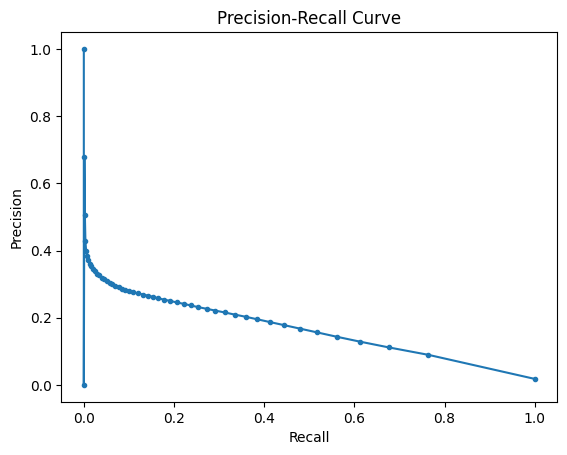

In [15]:
plot_pr_curve(stats['PRC'])

In [18]:
stats = evaluate_model(pl_model.eval(), datamodule.val_dataloader(), get_mask_preds_tinycd, device, threshold=0.20)
print(stats)

100%|██████████| 29/29 [00:18<00:00,  1.57it/s]

{'OA': 0.9913672804832458, 'F1': 0.6862306594848633, 'recall': 0.6937958002090454, 'precision': 0.6788287162780762, 'AP': 0.7484768629074097, 'PRC': (tensor([0.0136, 0.4002, 0.4694, 0.5154, 0.5494, 0.5778, 0.6028, 0.6252, 0.6456,
        0.6644, 0.6824, 0.6988, 0.7142, 0.7284, 0.7413, 0.7532, 0.7645, 0.7751,
        0.7850, 0.7949, 0.8040, 0.8115, 0.8191, 0.8258, 0.8325, 0.8399, 0.8469,
        0.8540, 0.8601, 0.8667, 0.8727, 0.8779, 0.8830, 0.8885, 0.8938, 0.8998,
        0.9053, 0.9100, 0.9160, 0.9214, 0.9267, 0.9311, 0.9350, 0.9405, 0.9470,
        0.9551, 0.9636, 0.9734, 0.9796, 0.0000, 1.0000], device='cuda:0'), tensor([1.0000, 0.9470, 0.9095, 0.8760, 0.8457, 0.8173, 0.7900, 0.7637, 0.7382,
        0.7132, 0.6890, 0.6649, 0.6419, 0.6193, 0.5978, 0.5773, 0.5573, 0.5380,
        0.5190, 0.4985, 0.4793, 0.4628, 0.4467, 0.4307, 0.4128, 0.3935, 0.3740,
        0.3552, 0.3373, 0.3211, 0.3055, 0.2903, 0.2756, 0.2609, 0.2463, 0.2318,
        0.2167, 0.2013, 0.1860, 0.1705, 0.1548, 0.1383,

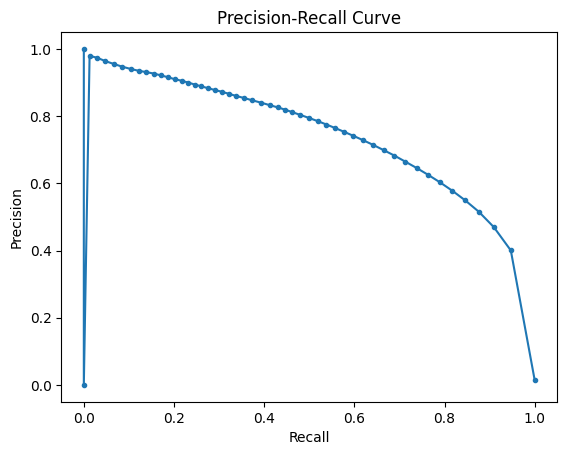

In [17]:
plot_pr_curve(stats['PRC'])